In [422]:
from lxml import etree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as ticker
from os.path import join
import os
import json

In [423]:
N_VECTORS = 1e6
ONE_MB = 2 ** 20
FLOAT_SIZE_B = 4
VECTOR_DIM = 128
VECTOR_SIZE = VECTOR_DIM * FLOAT_SIZE_B
VECTOR_SIZE_MB = VECTOR_SIZE / ONE_MB
NS_PER_S = 1e9
S_PER_MIN = 60
MS_PER_S = 1e3
US_TO_NS = 1e3

In [424]:
# read benchmark parameters like `n_lists` and `n_probes` which are stored in a `Warning` tag (key := value) preceding the `BenchmarkResults` tag
def extract_benchmark_params(element):
    params = {}
    for sibling in element.itersiblings(preceding=True):
        if sibling.tag == 'Warning':
            parts = list(map(lambda s: s.strip(), sibling.text.split(':=')))
            params[parts[0]] = parts[1]
    return params

def get_abbreviation_to_param_map():
    with open('parameter_abbreviations.json') as f:
        abbreviations = json.load(f)
    return {v: k for k, v in abbreviations.items()}

def get_file_params(filename):
    params = {}
    abbr_to_param = get_abbreviation_to_param_map()
    # remove .xml  extension explicitly
    filename = filename[:-4]
    catch_tags, params_str = filename.split(' ', 1)
    params['catch_tags'] = catch_tags
    for part in params_str.split(' '):
        key, value = part.split('=')
        params[abbr_to_param.get(key, key)] = value
    return params

def parse_xml(subdir, filename, format='throughput'):
    directory = join('benchmarks', subdir) if subdir else 'benchmarks'
    filepath = join(directory, filename)
    tree = ET.parse(filepath)
    root = tree.getroot()
    results = []

    if format == 'throughput':
        for match in root.iter('BenchmarkResults'):
            result = extract_benchmark_params(match)
            result['mean'] = match.find('mean').get('value')
            result['std'] = match.find('standardDeviation').get('value')
            results.append(result)
    elif format == 'latency':
        for match in root.iter('Warning'):
            if not match.text.strip().startswith('latency_99th'):
                continue
            result = extract_benchmark_params(match)
            result['latency_99th'] = match.text.split(':=')[1].strip()
            results.append(result)
    elif format == 'recall':
        for match in root.iter('Warning'):
            if not match.text.strip().startswith('Recall'):
                continue
            result = extract_benchmark_params(match)
            result['recall@1'] = match.text.split(':=')[1].strip()
            results.append(result)
    else:
        raise ValueError('Unknown format: {}'.format(format))

    return results

In [425]:
def results_to_df(results, dataset='SIFT1M'):
    df = pd.DataFrame(results)

    if dataset == 'SIFT1M':
        N_QUERY_VECTORS = 1e4
    elif dataset == 'SIFT10M':
        N_QUERY_VECTORS = 1e5
    elif dataset == 'SIFT100M':
        N_QUERY_VECTORS = 1e6
    elif dataset in ['SIFT1000M', 'SIFT1B']:
        N_QUERY_VECTORS = 1e7
    else:
        raise ValueError('Unknown dataset: {}'.format(dataset))

    columns = []

    if 'O' in df.columns:
        df['O'] = df['O'].astype(int)
        columns += ['O']

    if 'max_n_threads' in df.columns:
        df['max_n_threads'] = df['max_n_threads'].astype(int)
        columns += ['max_n_threads']

    if 'DYNAMIC_INSERTION' in df.columns:
        df['DYNAMIC_INSERTION'] = (df['DYNAMIC_INSERTION'] == '1').astype(bool)
        columns += ['DYNAMIC_INSERTION']

    if 'MAX_BUFFER_SIZE' in df.columns:
        df['MAX_BUFFER_SIZE'] = df['MAX_BUFFER_SIZE'].astype(int)
        columns += ['MAX_BUFFER_SIZE']

    if 'n_lists' in df.columns:
        df['n_lists'] = df['n_lists'].astype(int)
        columns += ['n_lists']

    if 'n_probes' in df.columns:
        df['n_probes'] = df['n_probes'].astype(int)
        columns += ['n_probes']

    if 'n_results' in df.columns:
        df['n_results'] = df['n_results'].astype(int)
        columns += ['n_results']
        
    if 'mean' in df.columns:
        df['mean'] = df['mean'].astype(float) / NS_PER_S / N_QUERY_VECTORS
        columns += ['mean']

    if 'std' in df.columns:
        df['std'] = df['std'].astype(float) / NS_PER_S / N_QUERY_VECTORS
        columns += ['std']
    
    if 'latency_50th' in df.columns:
        df['latency_50th'] = df['latency_50th'].astype(float) / NS_PER_S
        columns += ['latency_50th']

    if 'latency_95th' in df.columns:
        df['latency_95th'] = df['latency_95th'].astype(float) / NS_PER_S
        columns += ['latency_95th']

    if 'latency_99th' in df.columns:
        df['latency_99th'] = df['latency_99th'].astype(float) / NS_PER_S
        columns += ['latency_99th']

    if 'recall@1' in df.columns:
        df['recall@1'] = df['recall@1'].astype(float)
        columns += ['recall@1']

    return df[columns]

Search space size for the vector search and search_preassigned
- Since we normalized the measurements by dividing by the number of query vectors, here we consider the search space size and the size of the candidates for a single query vector as well.
- Since we're searching through the SIFT1M dataset with $10^6$ vectors, we can compute the number of vectors per list `n_vectors_per_list` given the number of lists `n_lists`:
$$
\text{n\_vectors\_per\_list} = \frac{10^6}{\text{n\_lists}}
$$.
- We find the total number of vectors which need to be searched as the product of `n_vectors_per_list` and `n_probes`, therefore:

$$
\text{n\_vectors\_to\_search} = \text{n\_vectors\_per\_list} * \text{n\_probe} = \frac{10^6}{\text{n\_lists}} * \text{n\_probe}
$$.

- Assuming $128$-dimensional vectors of floats, we can estimate the size of the search space in MB as:
$$
\text{vector\_size\_mb} = \frac{128 * 4}{2^{20}}
$$
$$
\text{search\_space\_size\_mb} = \text{n\_vectors\_to\_search} * \text{vector\_size\_mb}
$$.

- For `preassign_query`, the search space is only proportional to the number of lists since we only need to compare against one centroid per list. Therefore, we can compute the search space size as:
$$
\text{centroids\_total\_size\_mb} = \text{n\_lists} * \text{vector\_size\_mb}
$$.

In [426]:
def add_space_estimates(df):
  df['n_vectors_to_search'] = (N_VECTORS / df['n_lists'] * df['n_probes']).round(1)
  df['search_space_size_mb'] = (df['n_vectors_to_search'] * VECTOR_SIZE_MB).round(1)
  df['centroids_total_size_mb'] = (df['n_lists'] * VECTOR_SIZE_MB).round(1)

Plotting

In [427]:
def plot(df,
         y_col,
         ylabel,
         title,
         yerr_col=None,
         legend_loc='best',
         yformatter=ticker.ScalarFormatter(),
         yaxis_log=False,
         mode='n_probes',
         xaxis_locator=ticker.LogLocator(base=2),
         xaxis_formatter=ticker.FormatStrFormatter('%d'),
         subtitle='',
         scatter=False):

    if mode == 'n_probes':
        x_col = 'n_probes'
        series_col = 'n_lists'
        x_label = 'Number of probes'
        legend_title = 'Number of lists'
    elif mode == 'n_lists':
        x_col = 'n_lists'
        series_col = 'n_probes'
        x_label = 'Number of lists'
        legend_title = 'Number of probes'
    elif mode == 'max_n_threads':
        x_col = 'max_n_threads'
        series_col = 'O'
        x_label = 'Maximum number of threads'
        legend_title = 'Optimization level'
    elif mode == 'n_results':
        x_col = 'n_results'
        series_col = 'n_probes'
        x_label = 'Number of results'
        legend_title = 'Number of probes'
    elif mode == 'MAX_BUFFER_SIZE':
        x_col = 'MAX_BUFFER_SIZE'
        series_col = 'DYNAMIC_INSERTION'
        x_label = 'Max buffer size'
        legend_title = 'Dynamic insertion'
    else:
        raise ValueError(f'Invalid value for plot: {plot}')
    fig, ax = plt.subplots(tight_layout=True)
    ax.set_prop_cycle(marker_cycler)
    title_txt = f'{title}\n{subtitle}' if subtitle else title
    ax.set_title(title_txt)
    sorted_uniques = sorted(df[series_col].unique())
    for label in reversed(sorted_uniques):
        params = {'markersize': 7, 'lw': 2, 'label': f'{label}'}
        df_subset = df[df[series_col] == label]
        if yerr_col:
            params = {**params, 'capsize': 8, 'capthick': 1}
            ax.errorbar(x=df_subset[x_col],
                        y=df_subset[y_col],
                        yerr=df_subset[yerr_col],
                        **params)
        elif scatter:
            params.pop('markersize')
            ax.scatter(df_subset[x_col], df_subset[y_col], **params)
        else:
            ax.plot(df_subset[x_col], df_subset[y_col], **params)

    ax.set_xlabel(x_label)
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(xaxis_locator)
    ax.xaxis.set_major_formatter(xaxis_formatter)
    ax.xaxis.set_minor_locator(ticker.NullLocator())

    if yaxis_log:
        ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(yformatter)

    ax.legend(title=legend_title, loc=legend_loc)

    plt.show()


marker_cycler = cycler(
    color=[
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
        '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
    ],
    marker=['o', 's', '^', 'd', '*', '+', 'x', 'v', 'p', 'h'])

s_to_ms_formatter = ticker.FuncFormatter(
    lambda x, pos: '{:.1f}'.format(x * 1000).rstrip('0').rstrip('.'))
s_to_us_formatter = ticker.FuncFormatter(
    lambda x, pos: '{:0.1f}'.format(x * 1e6).rstrip('0').rstrip('.'))
mb_to_gb_formatter = ticker.FuncFormatter(
    lambda x, pos: '{:0.1f}'.format(x / 2**10).rstrip('0').rstrip('.'))
speedup_formatter = ticker.FuncFormatter(
    lambda x, pos: '{:0.1f}'.format(x).rstrip('0').rstrip('.'))

base10_locator = ticker.LogLocator(base=10)
base10_formatter = ticker.LogFormatterSciNotation(base=10)

Throughput

In [428]:
def get_vector_throughput(df, n_vectors_column, seconds_column):
    vectors_per_s = (df[n_vectors_column] / df[seconds_column]).round(1)
    mb_per_s = (vectors_per_s * VECTOR_SIZE / ONE_MB).round(1)
    return vectors_per_s, mb_per_s

def add_centroids_search_throughput(centroids_df):
    centroids_df['vectors_per_s'], centroids_df['mb_per_s'] = get_vector_throughput(centroids_df, 'n_lists', 'mean')
    return centroids_df

def add_search_throughput(search_df):
  search_df['n_vectors_per_s'], search_df['mb_per_s'] = get_vector_throughput(search_df, 'n_vectors_to_search', 'mean')
  return search_df

Speedup

In [429]:
def get_speedup(old_df, new_df, column, invert=False):
  speedup = new_df[column] / old_df[column]
  if invert:
    speedup = 1 / speedup
  return speedup

# `bulk_insert_entries`

## Finding the optimal insertion strategy and buffer size

In [430]:
def merge_results(subdir, filter_file, format):
    results = []
    for f in os.listdir(join('benchmarks', subdir)):
        if filter_file(f):
            params = get_file_params(f)
            for result in parse_xml(subdir, f, format=format):
                result.update(params)
                results.append(result)
    return results


In [415]:
bie_sift10m_df = results_to_df(merge_results('insertion strategy and buffer size', lambda f: 'SIFT10M' in f, 'throughput'), dataset='SIFT10M')
bie_sift10m_df = bie_sift10m_df.sort_values(['DYNAMIC_INSERTION', 'MAX_BUFFER_SIZE'])
bie_sift10m_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,mean,std
12,3,False,10,0.001581,0.000036
7,3,False,100,0.001447,0.000076
11,3,False,1000,0.001679,0.000047
10,3,False,10000,0.001637,0.000032
14,3,False,100000,0.001623,0.000080
0,3,False,1000000,0.001769,0.000108
3,3,False,10000000,0.001554,0.000020
9,3,True,1,0.001536,0.000125
13,3,True,10,0.001553,0.000077
1,3,True,100,0.001481,0.000093


In [419]:
bie_sift100m_df = results_to_df(merge_results('insertion strategy and buffer size', lambda f: 'SIFT100M' in f, 'throughput'), dataset='SIFT100M')
bie_sift100m_df = bie_sift100m_df.sort_values(['DYNAMIC_INSERTION', 'MAX_BUFFER_SIZE'])
bie_sift100m_df

,O,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,mean,std
2,3,False,1,0.002124,0.000208
3,3,False,1000,0.001891,0.000089
8,3,False,10000,0.001624,0.000053
0,3,False,100000,0.001742,0.000059
11,3,False,1000000,0.001680,0.000024
1,3,True,1,0.001804,0.000036
9,3,True,10,0.001804,0.000042
4,3,True,100,0.001839,0.000040
10,3,True,1000,0.001799,0.000010
5,3,True,10000,0.001705,0.000007


**Execution time**

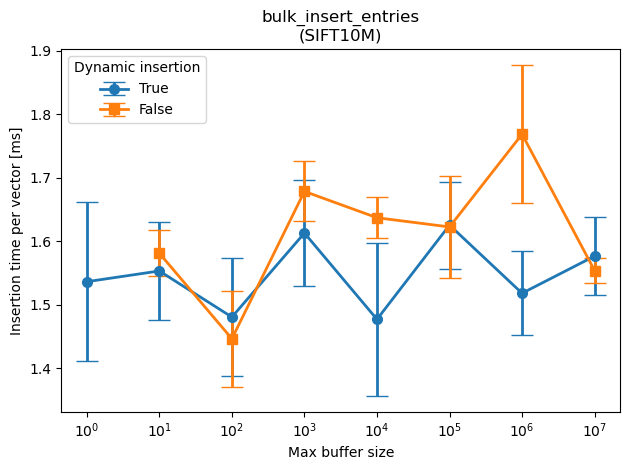

In [420]:
plot(bie_sift10m_df, 'mean', 'Insertion time per vector [ms]', 'bulk_insert_entries', subtitle='(SIFT10M)', yerr_col='std', mode='MAX_BUFFER_SIZE', xaxis_locator=base10_locator, yformatter=s_to_ms_formatter, xaxis_formatter=base10_formatter)

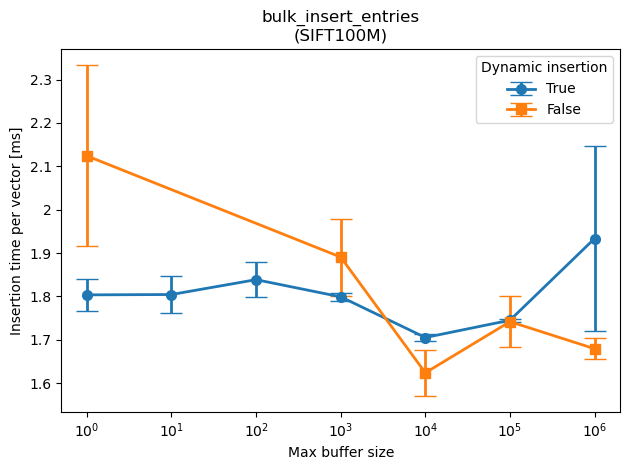

In [421]:
plot(bie_sift100m_df, 'mean', 'Insertion time per vector [ms]', 'bulk_insert_entries', subtitle='(SIFT100M)', yerr_col='std', mode='MAX_BUFFER_SIZE', xaxis_locator=base10_locator, yformatter=s_to_ms_formatter, xaxis_formatter=base10_formatter)

## Optimization experiment: Sorting

In [215]:
bie_unsorted = [{'n_lists': 512, 'n_probes': 1, 'mean': 2.02024e+09, 'std': 4.9847e+06}, {'n_lists': 1024, 'n_probes': 1, 'mean': 5.54063e10, 'std': 1.41458e09}]
unsorted_df = results_to_df(bie_unsorted)
unsorted_df

,n_lists,n_probes,mean,std
0,512,1,0.000202,4.984700e-07
1,1024,1,0.005541,1.414580e-04


In [216]:
bie_sorted = [{'n_lists': 512, 'n_probes': 1, 'mean': 2.84686e+09, 'std': 1.1119e+07},{'n_lists': 1024, 'n_probes': 1, 'mean': 3.68418e+09, 'std': 7.2396e07}]
sorted_df = results_to_df(bie_sorted)
sorted_df['mean_speedup'] = get_speedup(old_df=unsorted_df, new_df=sorted_df, column='mean', invert=True)
sorted_df

,n_lists,n_probes,mean,std,mean_speedup
0,512,1,0.000285,0.000001,0.709638
1,1024,1,0.000368,0.000007,15.038977


# No SIMD, No OpenMP

## `preassign_query()`

Parsing measurements from xml output of testing framework

In [217]:
centroids_df = results_to_df(parse_xml('Vanilla', '[RootIndex][preassign_query][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=0 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=0 SIM=0 NTH=16.xml', format='throughput'))
add_space_estimates(centroids_df)
add_centroids_search_throughput(centroids_df)
centroids_df

,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
0,256,1,8,0.000032,2.746270e-08,3906.2,1.9,0.1,8060148.9,3935.6
1,256,2,8,0.000032,1.109550e-07,7812.5,3.8,0.1,7936729.4,3875.4
2,256,4,8,0.000033,1.595460e-07,15625.0,7.6,0.1,7761362.4,3789.7
3,256,8,8,0.000034,7.283710e-09,31250.0,15.3,0.1,7543300.3,3683.3
4,256,16,8,0.000036,1.073740e-07,62500.0,30.5,0.1,7043571.1,3439.2
5,256,32,8,0.000040,1.317220e-08,125000.0,61.0,0.1,6322205.3,3087.0
6,256,64,8,0.000046,5.956380e-09,250000.0,122.1,0.1,5573068.1,2721.2
7,256,128,8,0.000053,3.407370e-08,500000.0,244.1,0.1,4870781.6,2378.3
8,512,1,8,0.000063,1.045610e-07,1953.1,1.0,0.2,8136851.7,3973.1
9,512,2,8,0.000063,4.573240e-08,3906.2,1.9,0.2,8081254.5,3945.9


**Search Space Size**

Here, we see how the search space behaves as we increase the number of lists and probes.
- The search space for the search_preassigned, i.e. `preassign_query`, grows linearly but only in proportion to the number of lists.


In [218]:
centroids_mean_by_n_lists_df = centroids_df.groupby('n_lists').mean()
centroids_std_by_n_lists_df = centroids_df.groupby('n_lists').std()
centroids_mean_by_n_lists_df

,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
n_lists,,,,,,,,,
256,31.875,8.0,0.000038,5.822796e-08,124511.7125,60.7875,0.1,6.888896e+06,3363.7125
512,31.875,8.0,0.000072,3.177875e-08,62255.8500,30.4000,0.2,7.256728e+06,3543.3250
1024,31.875,8.0,0.000137,3.949456e-08,31127.9250,15.2000,0.5,7.547359e+06,3685.2500
2048,31.875,8.0,0.000266,2.198498e-07,15563.9625,7.6000,1.0,7.722237e+06,3770.6250
4096,31.875,8.0,0.000517,1.441097e-06,7781.9750,3.8000,2.0,7.927460e+06,3870.8250


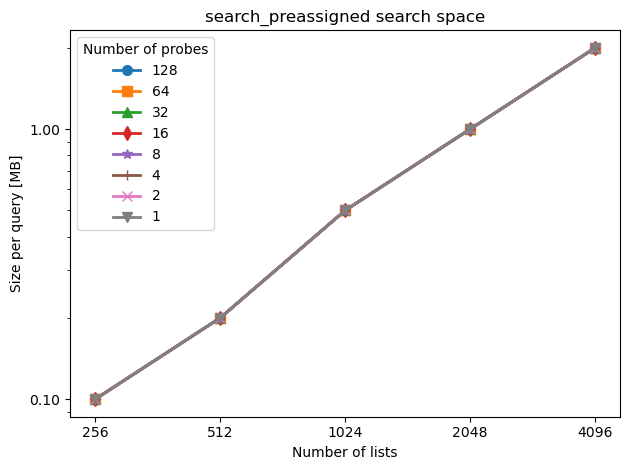

In [219]:
plot(centroids_df, 'centroids_total_size_mb', 'Size per query [MB]', 'search_preassigned search space', mode='n_lists', yaxis_log=True)

In [220]:
centroids_mean_by_n_probe_df = centroids_df.groupby('n_probes').mean()
centroids_std_by_n_probe_df = centroids_df.groupby('n_probes').std()
centroids_mean_by_n_probe_df

,n_lists,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
n_probes,,,,,,,,,
1,1587.2,8.0,0.000196,6.475132e-07,1513.66,0.74,0.76,8089439.72,3949.92
2,1587.2,8.0,0.000197,1.425713e-07,3027.34,1.48,0.76,8044221.16,3927.86
4,1587.2,8.0,0.000196,9.726547e-08,6054.68,2.96,0.76,8022782.08,3917.38
8,1587.2,8.0,0.000198,1.374486e-07,12109.36,5.92,0.76,7894758.38,3854.88
16,1587.2,8.0,0.000201,1.135720e-07,24218.74,11.82,0.76,7646552.54,3733.66
32,1587.2,8.0,0.000207,5.537902e-07,48437.50,23.64,0.76,7256805.44,3543.36
64,1587.2,8.0,0.000219,6.246832e-07,96875.00,47.30,0.76,6699580.32,3271.26
128,1587.2,8.0,0.000236,5.478735e-07,193750.00,94.60,0.76,6094147.18,2975.66


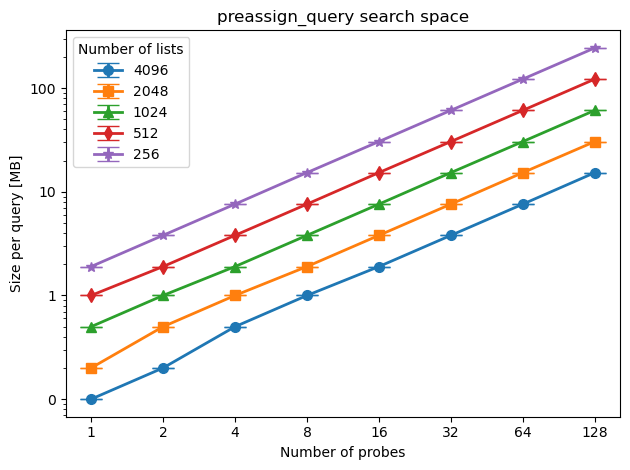

In [221]:
plot(centroids_df, 'search_space_size_mb', 'Size per query [MB]', 'preassign_query search space', yerr_col='std', yaxis_log=True)

**Execution Time**

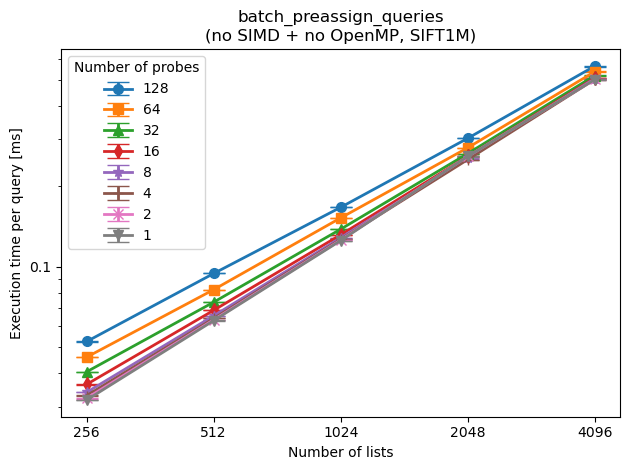

In [222]:
plot(df=centroids_df, y_col='mean', yerr_col='std', ylabel='Execution time per query [ms]', title='batch_preassign_queries', subtitle='(no SIMD + no OpenMP, SIFT1M)', legend_loc='upper left', mode='n_lists', yaxis_log=True, yformatter=s_to_ms_formatter)

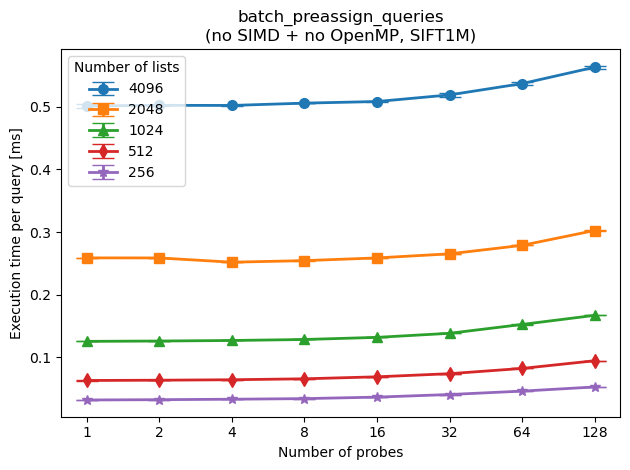

In [223]:
plot(df=centroids_df, y_col='mean', yerr_col='std', ylabel='Execution time per query [ms]', title='batch_preassign_queries', subtitle='(no SIMD + no OpenMP, SIFT1M)', legend_loc='upper left', yformatter=s_to_ms_formatter)

**Throughput**

- Search space = number of centroids to compare against = `n_lists`
- Candidates = number of closest centroids to find = `n_probes`
- For a fixed `n_lists` and increasing `n_probes`, we expect the throughput to decrease since we need to compare against the current list of `n_probes` candidates (using a heap) while searching through the constant search space which is fixed with the number of lists.

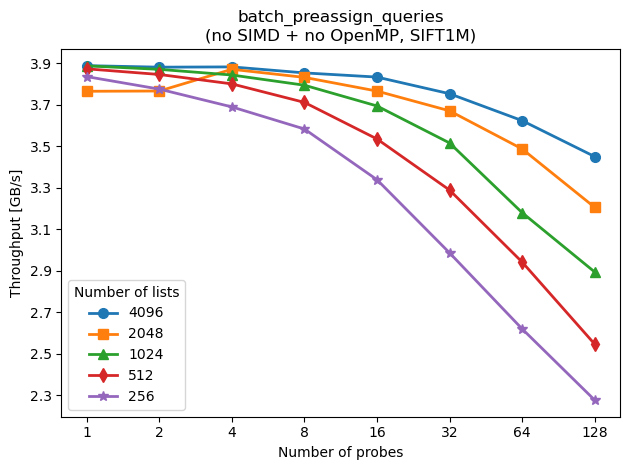

In [224]:
plot(df=centroids_df, y_col='mb_per_s', ylabel='Throughput [GB/s]', title='batch_preassign_queries', subtitle='(no SIMD + no OpenMP, SIFT1M)', yformatter=mb_to_gb_formatter)

## `search_preassigned`

In [226]:
search_df = results_to_df(parse_xml('Vanilla', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=0 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=0 SIM=0 NTH=16.xml', format='throughput'))
add_space_estimates(search_df)
add_search_throughput(search_df)
search_df

,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,256,1,8,0.000550,8.306890e-06,3906.2,1.9,0.1,7097690.9,3465.7
1,256,2,8,0.001073,4.684590e-06,7812.5,3.8,0.1,7279359.7,3554.4
2,256,4,8,0.002101,9.837930e-06,15625.0,7.6,0.1,7436510.1,3631.1
3,256,8,8,0.004112,2.963750e-06,31250.0,15.3,0.1,7600595.4,3711.2
4,256,16,8,0.008092,1.976840e-06,62500.0,30.5,0.1,7724011.8,3771.5
5,256,32,8,0.015884,7.525730e-06,125000.0,61.0,0.1,7869702.9,3842.6
6,256,64,8,0.031299,6.325990e-06,250000.0,122.1,0.1,7987450.1,3900.1
7,256,128,8,0.062226,3.882370e-05,500000.0,244.1,0.1,8035161.9,3923.4
8,512,1,8,0.000273,1.672410e-07,1953.1,1.0,0.2,7163159.8,3497.6
9,512,2,8,0.000535,1.966800e-06,3906.2,1.9,0.2,7302482.3,3565.7


**Execution Time**

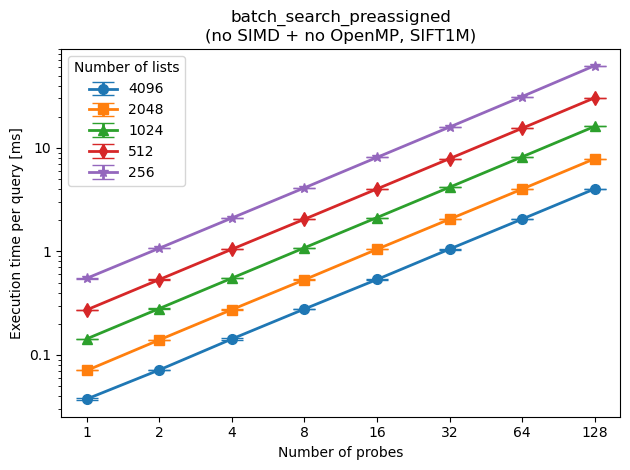

In [227]:
plot(df=search_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(no SIMD + no OpenMP, SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

**Throughput**
- Search space ~ 1 / number of lists * number of vectors per list = 1 / `n_lists` * `n_vectors_per_list`
- For a fixed `n_lists` and increasing `n_probes`, the throughput increases since we increase the search space size which reduces the relative overhead of the search.
- For a fixed `n_probes` and increasing `n_lists`, the throughput decreases since the length of the individual lists is smaller which reduces the search space size and could lead to more overhead.


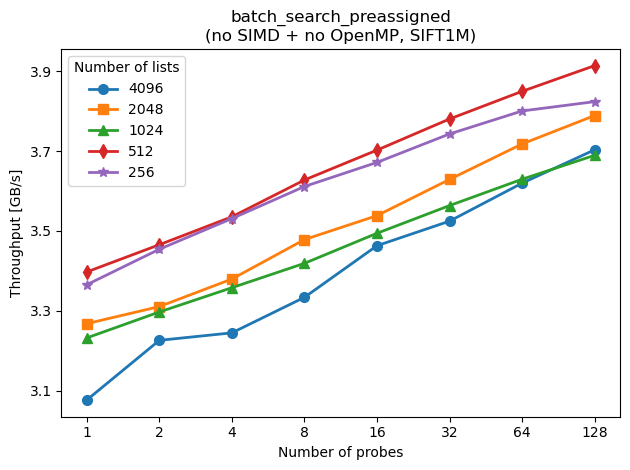

In [228]:
plot(df=search_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(no SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

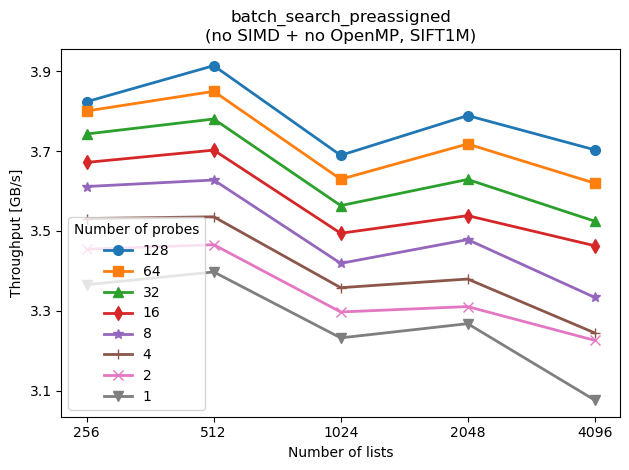

In [229]:
plot(df=search_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(no SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', mode='n_lists', yformatter=mb_to_gb_formatter)

# SIMD, no OpenMP

## `preassign_query()`

In [231]:
centroids_simd_df = results_to_df(parse_xml('SIMD', '[RootIndex][preassign_query][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=0 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=0 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(centroids_simd_df)
add_centroids_search_throughput(centroids_simd_df)
centroids_simd_df['mean_speedup'] = get_speedup(old_df=centroids_df, new_df=centroids_simd_df, column='mean', invert=True)
centroids_simd_df

,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,256,1,8,0.000008,1.186680e-07,3906.2,1.9,0.1,32675317.1,15954.7,4.053935
1,256,2,8,0.000008,3.615930e-08,7812.5,3.8,0.1,31438739.9,15350.9,3.961171
2,256,4,8,0.000009,1.345760e-09,15625.0,7.6,0.1,29479163.1,14394.1,3.798194
3,256,8,8,0.000009,3.662640e-09,31250.0,15.3,0.1,27067405.2,13216.5,3.588271
4,256,16,8,0.000011,1.078380e-08,62500.0,30.5,0.1,22856122.5,11160.2,3.244962
5,256,32,8,0.000014,1.384370e-08,125000.0,61.0,0.1,17670893.4,8628.4,2.795052
6,256,64,8,0.000019,5.353840e-09,250000.0,122.1,0.1,13209085.4,6449.7,2.370164
7,256,128,8,0.000025,2.959110e-08,500000.0,244.1,0.1,10174921.2,4968.2,2.088971
8,512,1,8,0.000016,1.597200e-07,1953.1,1.0,0.2,32825142.0,16027.9,4.034133
9,512,2,8,0.000016,8.874370e-09,3906.2,1.9,0.2,31971625.2,15611.1,3.956270


**Throughput**

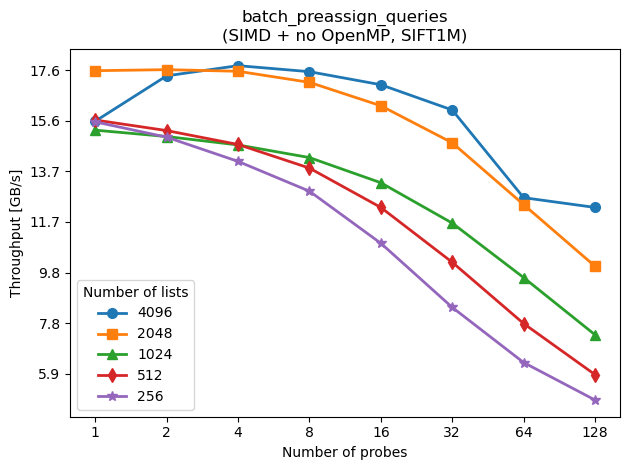

In [232]:
plot(df=centroids_simd_df, y_col='mb_per_s', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD speed-up for preassign_query(): 3.7x


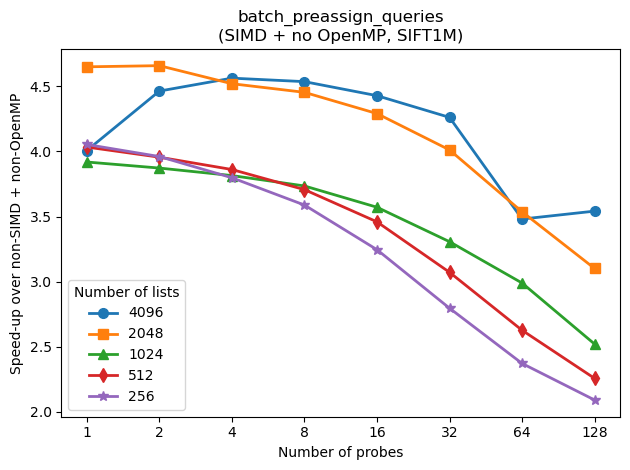

In [233]:
speedup = centroids_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for preassign_query(): {speedup:.1f}x')
plot(df=centroids_simd_df, y_col='mean_speedup', title='batch_preassign_queries', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Speed-up over non-SIMD + non-OpenMP')

## `search_preassigned()`

In [234]:
search_simd_df = results_to_df(parse_xml('SIMD', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=0 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=0 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_df)
add_search_throughput(search_simd_df)
search_simd_df['mean_speedup'] = get_speedup(old_df=search_df, new_df=search_simd_df, column='mean', invert=True)
search_simd_df

,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,256,1,8,0.000190,4.501750e-07,3906.2,1.9,0.1,20570206.9,10044.0,2.898155
1,256,2,8,0.000370,3.348330e-07,7812.5,3.8,0.1,21111669.6,10308.4,2.900210
2,256,4,8,0.000732,9.143930e-06,15625.0,7.6,0.1,21359985.1,10429.7,2.872313
3,256,8,8,0.001432,7.362780e-06,31250.0,15.3,0.1,21818816.5,10653.7,2.870672
4,256,16,8,0.002807,2.428840e-06,62500.0,30.5,0.1,22269175.5,10873.6,2.883110
5,256,32,8,0.005519,6.374400e-07,125000.0,61.0,0.1,22647389.2,11058.3,2.877795
6,256,64,8,0.010888,1.159850e-05,250000.0,122.1,0.1,22961690.7,11211.8,2.874721
7,256,128,8,0.021737,2.012290e-05,500000.0,244.1,0.1,23001936.8,11231.4,2.862660
8,512,1,8,0.000096,3.243310e-07,1953.1,1.0,0.2,20414776.1,9968.2,2.849968
9,512,2,8,0.000185,1.093660e-08,3906.2,1.9,0.2,21074609.8,10290.3,2.885952


**Execution Time**

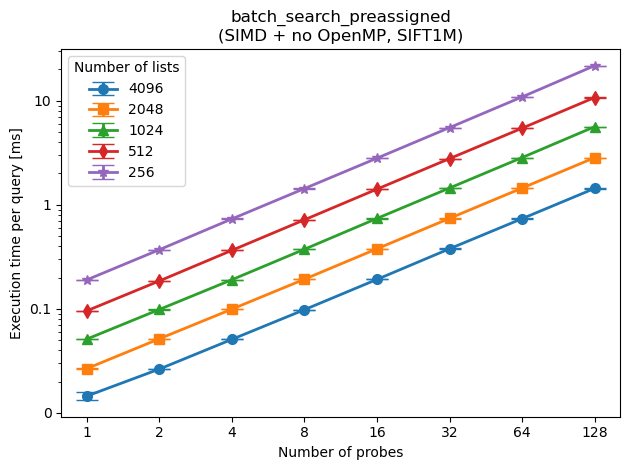

In [235]:
plot(df=search_simd_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

**Throughput**

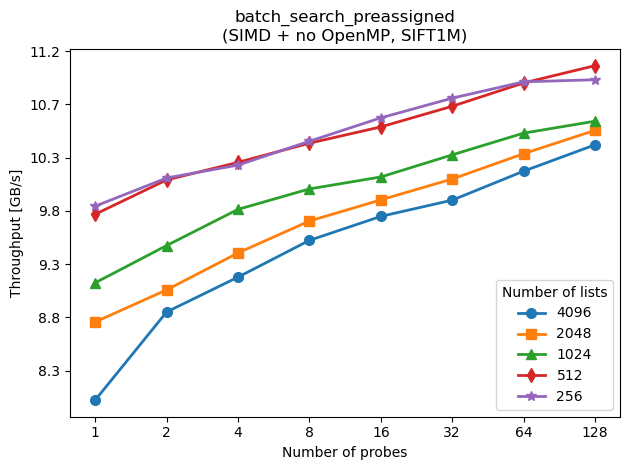

In [236]:
plot(df=search_simd_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD speed-up for search_preassigned(): 2.8x


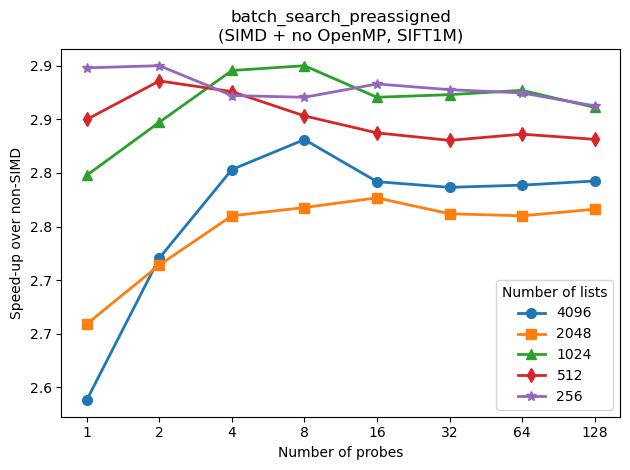

In [237]:
speedup = search_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for search_preassigned(): {speedup:.1f}x')
plot(df=search_simd_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + no OpenMP, SIFT1M)', ylabel='Speed-up over non-SIMD', yformatter=speedup_formatter)

# SIMD, OpenMP (over queries)

- The following benchmarks were executed on a `Intel Xeon E5-2640 @ 2.4 GHz` with 16 cores, each with 2 threads.
- OpenMP was configured to use up to `16` threads by configuring `OMP_NUM_THREADS`, an environment variable which sets the maximum thread count.

## `search_preassigned()`: Finding the optimal number of threads

In [432]:
threads_throughput_df = results_to_df(merge_results('max number of threads', lambda f: 'throughput' in f, 'throughput'))

threads_throughput_df = threads_throughput_df.sort_values(by=['O', 'max_n_threads'])
add_space_estimates(threads_throughput_df)
add_search_throughput(threads_throughput_df)
threads_throughput_df


,O,max_n_threads,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
22,1,1,False,10000,1024,16,8,0.000834,1.071470e-05,15625.0,7.6,0.5,18730026.3,9145.5
23,1,2,False,10000,1024,16,8,0.000423,1.041360e-06,15625.0,7.6,0.5,36907559.8,18021.3
24,1,4,False,10000,1024,16,8,0.000276,2.467870e-05,15625.0,7.6,0.5,56658918.7,27665.5
25,1,8,False,10000,1024,16,8,0.000231,2.453230e-05,15625.0,7.6,0.5,67576626.5,32996.4
26,1,16,False,10000,1024,16,8,0.000287,6.142890e-05,15625.0,7.6,0.5,54365033.8,26545.4
27,1,32,False,10000,1024,16,8,0.000265,2.110110e-05,15625.0,7.6,0.5,58869627.8,28744.9
28,1,64,False,10000,1024,16,8,0.000254,2.470220e-06,15625.0,7.6,0.5,61398752.0,29979.9
29,1,128,False,10000,1024,16,8,0.000218,8.574260e-06,15625.0,7.6,0.5,71662149.1,34991.3
30,1,256,False,10000,1024,16,8,0.000177,3.368030e-06,15625.0,7.6,0.5,88036104.7,42986.4
31,1,512,False,10000,1024,16,8,0.000168,7.161720e-07,15625.0,7.6,0.5,92737675.5,45282.1


**Execution Time**

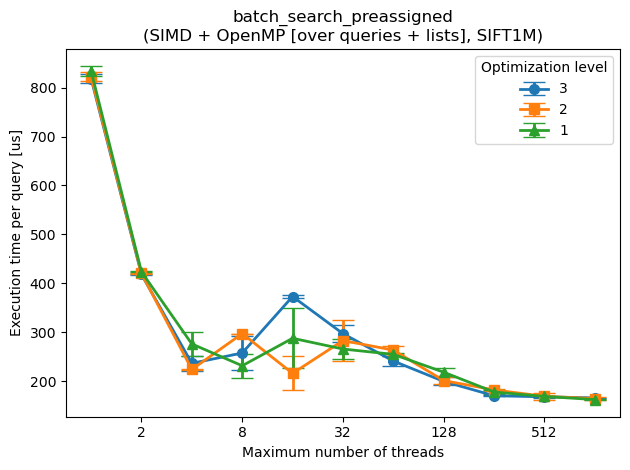

In [433]:
plot(df=threads_throughput_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Execution time per query [us]', mode='max_n_threads', yformatter=s_to_us_formatter, yaxis_log=False)

**Throughput**

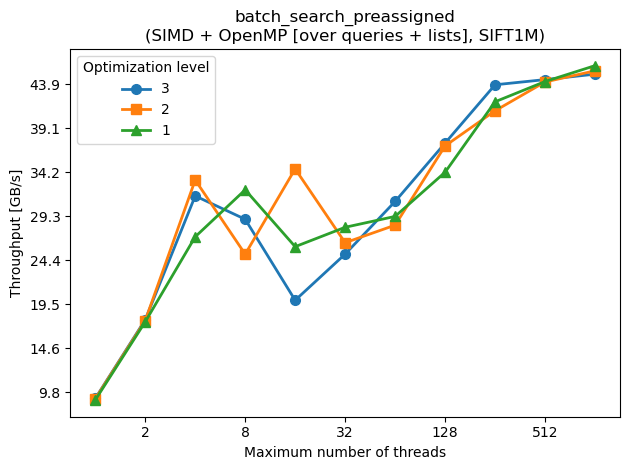

In [434]:
plot(df=threads_throughput_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', mode='max_n_threads', yformatter=mb_to_gb_formatter)

**Latency**

In [435]:
threads_latency_df = results_to_df(merge_results('max number of threads', lambda f: 'latency' in f, 'latency'))
threads_latency_df = threads_latency_df.sort_values(by=['O', 'max_n_threads'])
threads_latency_df

,O,max_n_threads,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,latency_50th,latency_95th,latency_99th
22,1,1,False,10000,1024,16,8,0.000994,0.001629,0.004756
23,1,2,False,10000,1024,16,8,0.000415,0.000675,0.003740
24,1,4,False,10000,1024,16,8,0.000237,0.000402,0.002237
25,1,8,False,10000,1024,16,8,0.000288,0.000456,0.001535
26,1,16,False,10000,1024,16,8,0.000446,0.000684,0.001246
27,1,32,False,10000,1024,16,8,0.000415,0.000715,0.004340
28,1,64,False,10000,1024,16,8,0.000852,0.001283,0.003187
29,1,128,False,10000,1024,16,8,0.001009,0.001445,0.003565
30,1,256,False,10000,1024,16,8,0.001366,0.001839,0.004151
31,1,512,False,10000,1024,16,8,0.002183,0.002802,0.005195


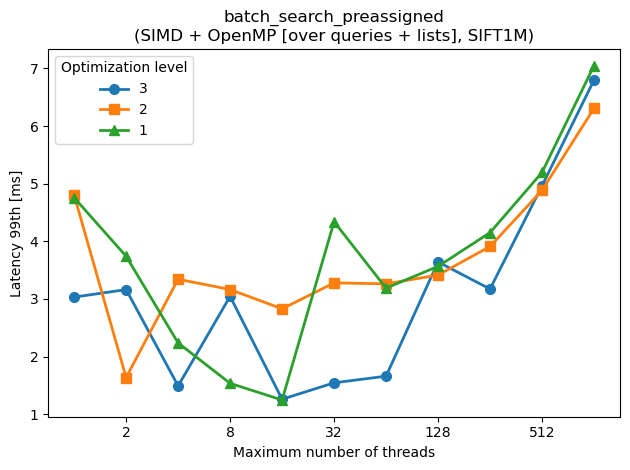

In [436]:
plot(df=threads_latency_df, y_col='latency_99th', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 99th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter)

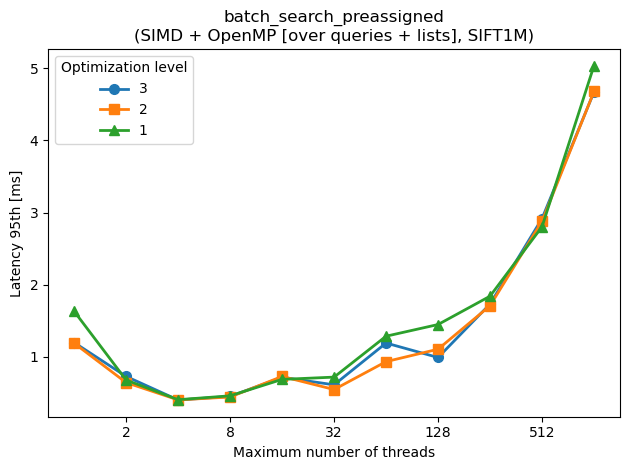

In [437]:
plot(df=threads_latency_df, y_col='latency_95th', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 95th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter)

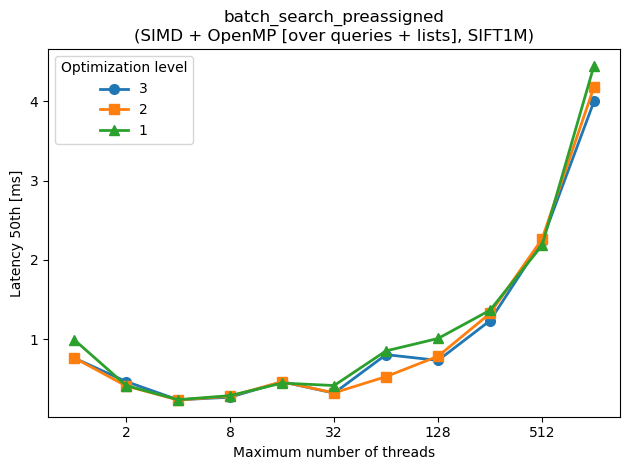

In [438]:
plot(df=threads_latency_df, y_col='latency_50th', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 50th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter)

*Service level objective*
- Latency 95th percentile: 1 ms
- Latency 99th percentile: 2 ms


In [439]:
# filter by latency_95th <= 1ms
threads_latency_sla_df = threads_latency_df[threads_latency_df['latency_95th'] <= 1e-3]
# filter by latency_99th <= 2ms
threads_latency_sla_df = threads_latency_df[threads_latency_df['latency_99th'] <= 2e-3]
threads_latency_sla_df

,O,max_n_threads,DYNAMIC_INSERTION,MAX_BUFFER_SIZE,n_lists,n_probes,n_results,latency_50th,latency_95th,latency_99th
25,1,8,False,10000,1024,16,8,0.000288,0.000456,0.001535
26,1,16,False,10000,1024,16,8,0.000446,0.000684,0.001246
12,2,2,False,10000,1024,16,8,0.000410,0.000639,0.001636
2,3,4,False,10000,1024,16,8,0.000235,0.000398,0.001490
4,3,16,False,10000,1024,16,8,0.000462,0.000713,0.001259
5,3,32,False,10000,1024,16,8,0.000320,0.000609,0.001544
6,3,64,False,10000,1024,16,8,0.000805,0.001189,0.001660


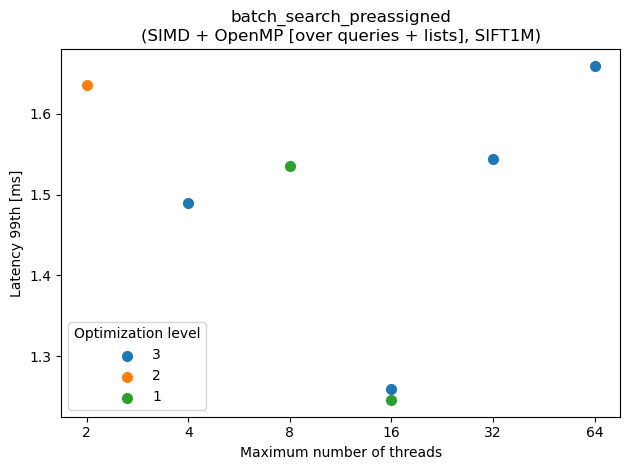

In [440]:
plot(df=threads_latency_sla_df, y_col='latency_99th', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 99th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter, scatter=True)

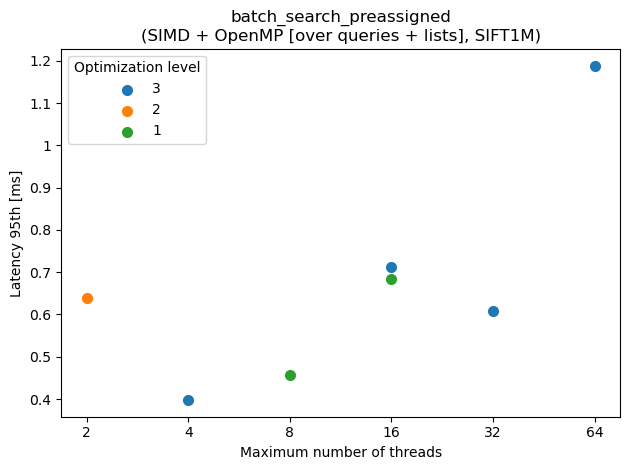

In [441]:
plot(df=threads_latency_sla_df, y_col='latency_95th', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 95th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter, scatter=True)

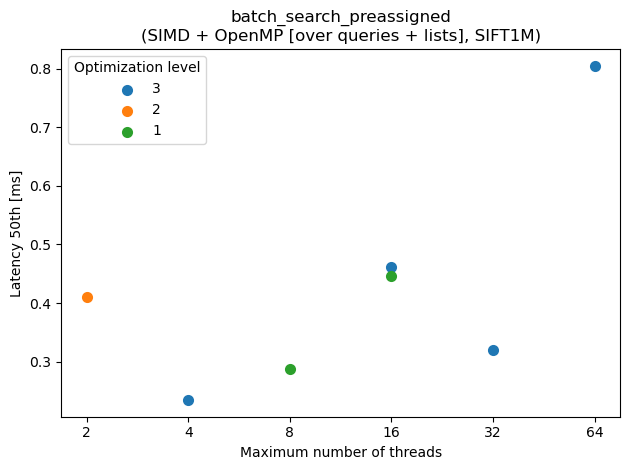

In [443]:
plot(df=threads_latency_sla_df, y_col='latency_50th', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Latency 50th [ms]', mode='max_n_threads', yformatter=s_to_ms_formatter, scatter=True)

=> Given the SLA of 1 ms (95th percentile) and 3 ms (99th percentile) and the fact that we want to maximize throughput (which increases with the number of threads), we should choose optimization level 1 with either 64 or 128 threads. Since the throughput is only marginally higher with 128 threads, we choose 64 threads, as the latency (both 95th and 99th percentile) is significantly lower.

## `preassign_query()`

In [244]:
centroids_simd_omp_df = results_to_df(parse_xml('OpenMP PMODE 1', '[RootIndex][preassign_query][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=1 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(centroids_simd_omp_df)
add_centroids_search_throughput(centroids_simd_omp_df)
centroids_simd_omp_df['mean_speedup'] = get_speedup(old_df=centroids_simd_df, new_df=centroids_simd_omp_df, column='mean', invert=True)
centroids_simd_omp_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,16,256,1,8,6.569770e-07,8.682070e-08,3906.2,1.9,0.1,389663565.1,190265.4,11.925319
1,16,256,2,8,5.624780e-07,1.466220e-08,7812.5,3.8,0.1,455128911.7,222230.9,14.476691
2,16,256,4,8,5.869810e-07,2.476700e-08,15625.0,7.6,0.1,436129959.9,212954.1,14.794516
3,16,256,8,8,8.586020e-07,4.507020e-08,31250.0,15.3,0.1,298159100.5,145585.5,11.015430
4,16,256,16,8,1.059810e-06,3.800120e-09,62500.0,30.5,0.1,241552731.1,117945.7,10.568404
5,16,256,32,8,9.454210e-07,1.834450e-08,125000.0,61.0,0.1,270778838.2,132216.2,15.323438
6,16,256,64,8,1.324930e-06,8.349150e-08,250000.0,122.1,0.1,193217754.9,94344.6,14.627641
7,16,256,128,8,1.636690e-06,6.929410e-08,500000.0,244.1,0.1,156413248.7,76373.7,15.372428
8,16,512,1,8,1.327670e-06,6.879570e-08,1953.1,1.0,0.2,385637997.4,188299.8,11.748251
9,16,512,2,8,1.103050e-06,3.261360e-08,3906.2,1.9,0.2,464167535.5,226644.3,14.518109


**Execution Time**

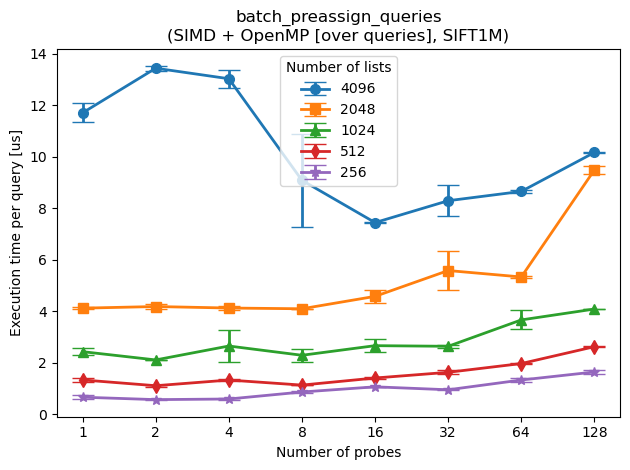

In [245]:
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, legend_loc='upper center')

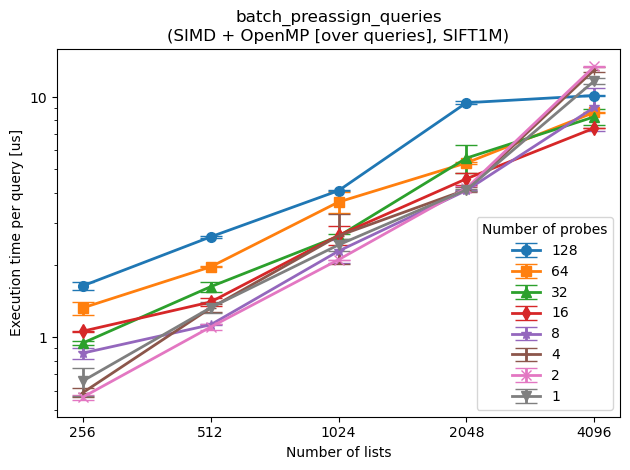

In [246]:
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, mode='n_lists', yaxis_log=True)

**Throughput**

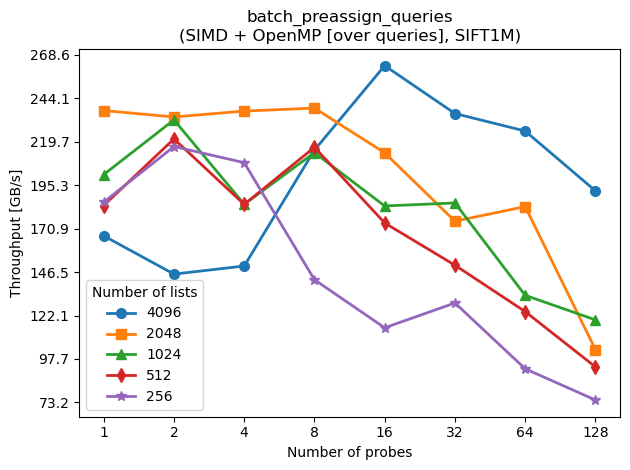

In [247]:
plot(df=centroids_simd_omp_df, y_col='mb_per_s', title='batch_preassign_queries', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP speed-up over SIMD-only: 13.7x


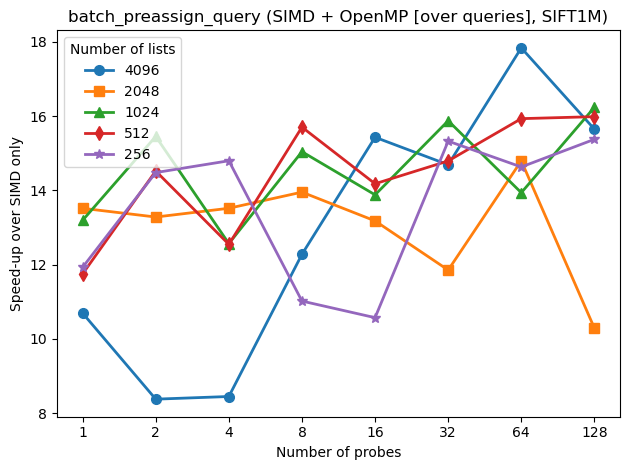

In [248]:
speedup = centroids_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up over SIMD-only: {speedup:.1f}x')
plot(df=centroids_simd_omp_df, y_col='mean_speedup', title='batch_preassign_query (SIMD + OpenMP [over queries], SIFT1M)', ylabel='Speed-up over SIMD only', yformatter=speedup_formatter)

## `search_preassigned()`

In [299]:
search_simd_omp_df = results_to_df(parse_xml('OpenMP PMODE 1', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=1 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_omp_df)
add_search_throughput(search_simd_omp_df)
search_simd_omp_df['mean_speedup'] = get_speedup(old_df=search_simd_df, new_df=search_simd_omp_df, column='mean', invert=True)
# filter for n_probes <= 64
search_simd_omp_df = search_simd_omp_df[search_simd_omp_df['n_probes'] <= 64]
search_simd_omp_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,16,256,1,8,0.000086,1.015670e-05,3906.2,1.9,0.1,45421775.3,22178.6,2.208134
1,16,256,2,8,0.000160,5.460470e-06,7812.5,3.8,0.1,48935783.7,23894.4,2.317949
2,16,256,4,8,0.000309,1.861300e-06,15625.0,7.6,0.1,50550474.4,24682.8,2.366597
3,16,256,8,8,0.000605,2.407140e-05,31250.0,15.3,0.1,51650160.7,25219.8,2.367230
4,16,256,16,8,0.001048,9.206980e-05,62500.0,30.5,0.1,59613513.7,29108.2,2.676952
5,16,256,32,8,0.001993,9.238780e-06,125000.0,61.0,0.1,62711337.2,30620.8,2.769032
6,16,256,64,8,0.003825,2.248090e-04,250000.0,122.1,0.1,65366483.7,31917.2,2.846763
8,16,512,1,8,0.000043,1.290490e-07,1953.1,1.0,0.2,45809565.8,22368.0,2.243942
9,16,512,2,8,0.000083,4.934350e-06,3906.2,1.9,0.2,47017445.9,22957.7,2.231000
10,16,512,4,8,0.000180,1.088910e-05,7812.5,3.8,0.2,43288304.3,21136.9,2.021604


**Execution Time**

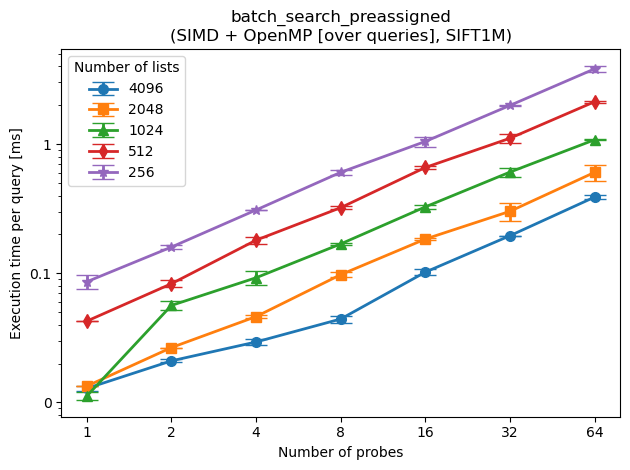

In [300]:
plot(df=search_simd_omp_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, yaxis_log=True)

**Throughput**

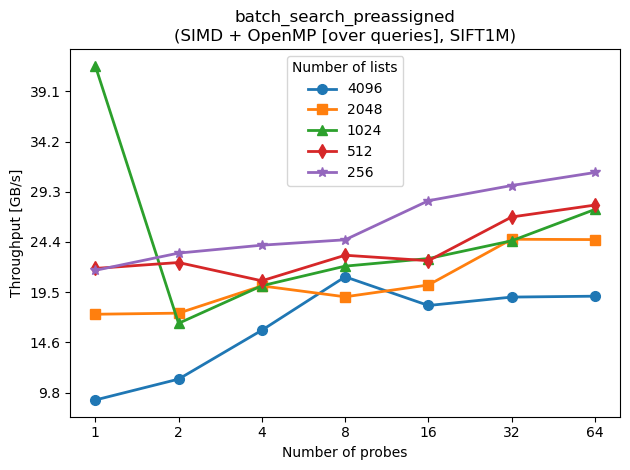

In [301]:
plot(df=search_simd_omp_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP speed-up over SIMD-only: 2.2x


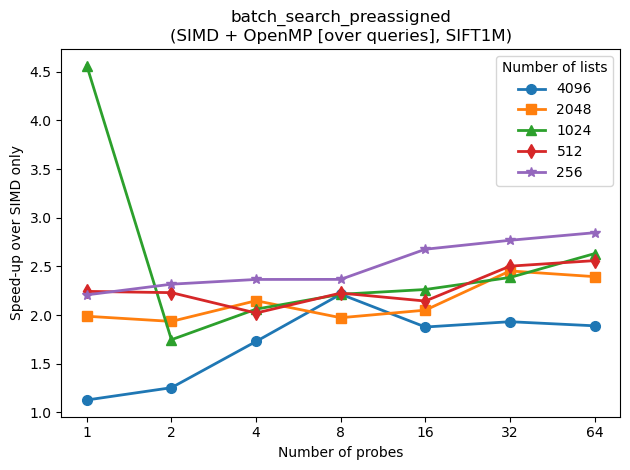

In [302]:
speedup = search_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up over SIMD-only: {speedup:.1f}x')
plot(df=search_simd_omp_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Speed-up over SIMD only')

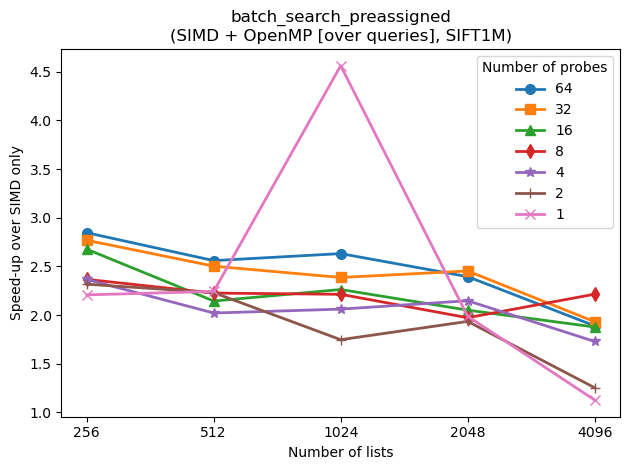

In [303]:
plot(df=search_simd_omp_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries], SIFT1M)', ylabel='Speed-up over SIMD only', mode='n_lists')

# SIMD, OpenMP (over queries and lists)

## `search_preassigned()`

In [256]:
search_simd_omp_pmode2_df = results_to_df(parse_xml('OpenMP PMODE 2', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=2 NDI=128 NLI=256,512,1024,2048,4096 NPR=1,2,4,8,16,32,64,128 NRE=8 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_omp_pmode2_df)
add_search_throughput(search_simd_omp_pmode2_df)
search_simd_omp_pmode2_df['mean_speedup'] = get_speedup(old_df=search_simd_df, new_df=search_simd_omp_pmode2_df, column='mean', invert=True)
search_simd_omp_pmode2_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,16,256,1,8,0.000080,7.306360e-06,3906.2,1.9,0.1,49060044.6,23955.1,2.385005
1,16,256,2,8,0.000181,7.496930e-06,7812.5,3.8,0.1,43101783.7,21045.8,2.041609
2,16,256,4,8,0.000319,4.027300e-06,15625.0,7.6,0.1,49026529.2,23938.7,2.295251
3,16,256,8,8,0.000658,4.621410e-05,31250.0,15.3,0.1,47525192.2,23205.7,2.178175
4,16,256,16,8,0.001207,4.660880e-05,62500.0,30.5,0.1,51800159.1,25293.0,2.326092
5,16,256,32,8,0.001941,7.446690e-05,125000.0,61.0,0.1,64402780.1,31446.7,2.843718
6,16,256,64,8,0.003229,3.275410e-04,250000.0,122.1,0.1,77432703.2,37808.9,3.372256
7,16,256,128,8,0.007659,4.162430e-04,500000.0,244.1,0.1,65284037.8,31877.0,2.838197
8,16,512,1,8,0.000054,3.187170e-06,1953.1,1.0,0.2,36146964.2,17649.9,1.770628
9,16,512,2,8,0.000077,2.318250e-06,3906.2,1.9,0.2,50479700.6,24648.3,2.395285


**Execution Time**

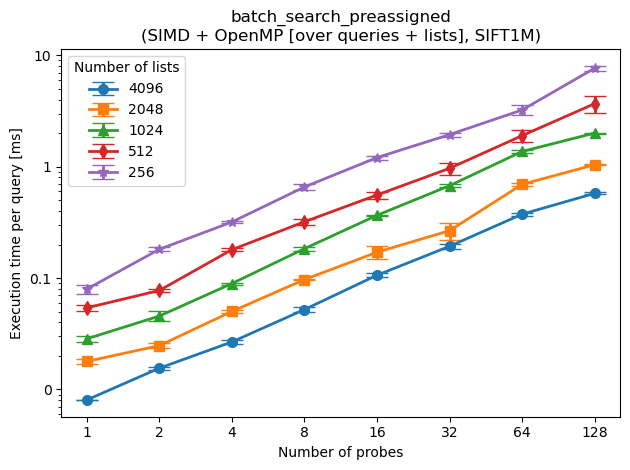

In [257]:
plot(df=search_simd_omp_pmode2_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, yaxis_log=True)

**Throughput**

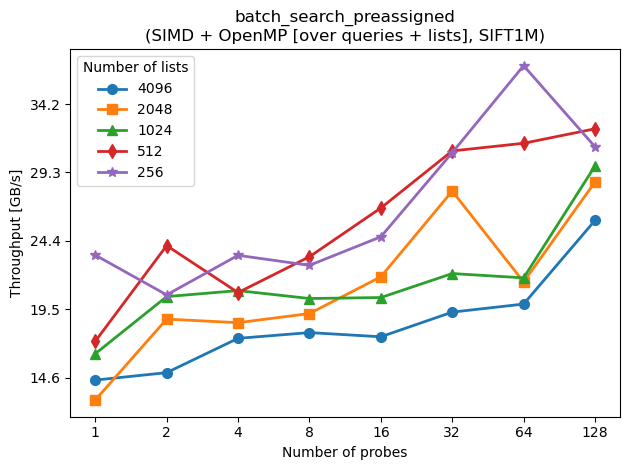

In [258]:
plot(df=search_simd_omp_pmode2_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

**Speedup**

Average SIMD + OpenMP [over queries + lists] speed-up over SIMD-only: 2.2x


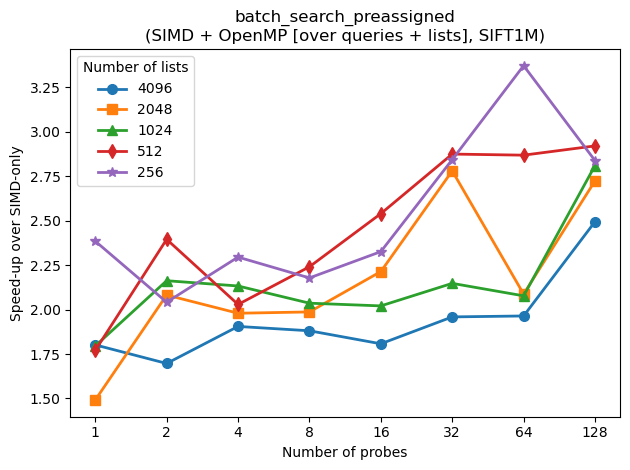

In [260]:
speedup = search_simd_omp_pmode2_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP [over queries + lists] speed-up over SIMD-only: {speedup:.1f}x')
plot(df=search_simd_omp_pmode2_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Speed-up over SIMD-only')

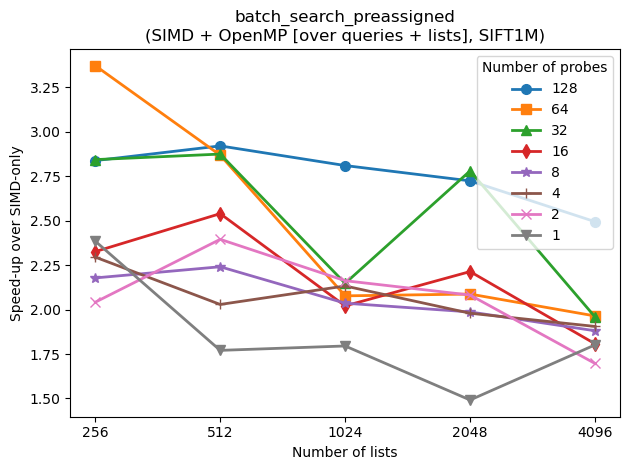

In [261]:
plot(df=search_simd_omp_pmode2_df, y_col='mean_speedup', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Speed-up over SIMD-only', mode='n_lists')

### Varying `n_probes` and `n_results`

In [289]:
search_simd_omp_pmode2_varying_nresults_df = results_to_df(parse_xml('number of results', '[StorageIndex][search_preassigned][SIFT1M][benchmark][throughput] DIN=1 BUF=10000 MEN=1 MSI=32 O=3 PMO=2 NDI=128 NLI=1024 NPR=1,2,4,8,16,32,64,128 NRE=1,2,4,8,16,32,64,128 OMP=1 SIM=1 NTH=16.xml', format='throughput'))
add_space_estimates(search_simd_omp_pmode2_varying_nresults_df)
add_search_throughput(search_simd_omp_pmode2_varying_nresults_df)
# filter n_probes in [1, 4, 16, 64]
search_simd_omp_pmode2_varying_nresults_df = search_simd_omp_pmode2_varying_nresults_df[search_simd_omp_pmode2_varying_nresults_df['n_probes'].isin([1, 4, 16, 64])]
search_simd_omp_pmode2_varying_nresults_df

,max_n_threads,n_lists,n_probes,n_results,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,16,1024,1,1,0.000011,9.127610e-09,976.6,0.5,0.5,92999781.0,45410.0
1,16,1024,1,2,0.000013,1.424190e-06,976.6,0.5,0.5,72549252.7,35424.4
2,16,1024,1,4,0.000018,1.656540e-06,976.6,0.5,0.5,54960886.9,26836.4
3,16,1024,1,8,0.000023,1.110310e-07,976.6,0.5,0.5,43331262.8,21157.8
4,16,1024,1,16,0.000029,5.832510e-07,976.6,0.5,0.5,34008085.9,16605.5
5,16,1024,1,32,0.000023,1.072190e-08,976.6,0.5,0.5,43387089.6,21185.1
6,16,1024,1,64,0.000021,1.217300e-06,976.6,0.5,0.5,47381316.3,23135.4
7,16,1024,1,128,0.000022,2.082890e-08,976.6,0.5,0.5,45242286.7,22091.0
16,16,1024,4,1,0.000089,6.538010e-06,3906.2,1.9,0.5,43870663.4,21421.2
17,16,1024,4,2,0.000090,4.179480e-06,3906.2,1.9,0.5,43253382.5,21119.8


**Execution Time**

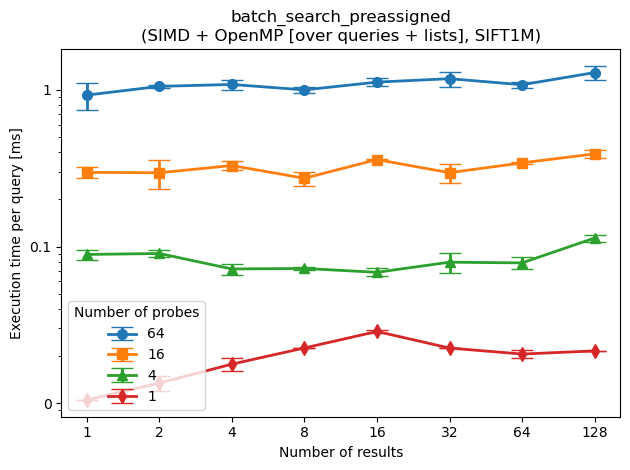

In [290]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='mean', yerr_col='std', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Execution time per query [ms]', yformatter=s_to_ms_formatter, mode='n_results', yaxis_log=True)

**Throughput**
- critical region

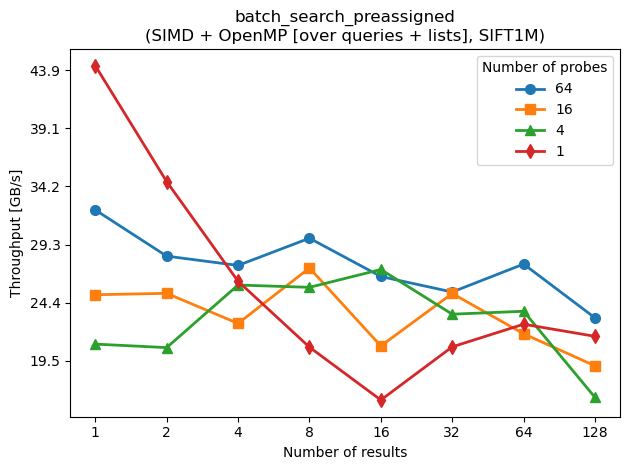

In [293]:
plot(df=search_simd_omp_pmode2_varying_nresults_df, y_col='mb_per_s', title='batch_search_preassigned', subtitle='(SIMD + OpenMP [over queries + lists], SIFT1M)', ylabel='Throughput [GB/s]', mode='n_results', yaxis_log=False, yformatter=mb_to_gb_formatter)

**Recall**


In [149]:
search_recall_simd_omp_pmode2_df = results_to_df(parse_xml_recall('preassign_query_recall_simd_omp_pmode2.xml'))
# add_space_estimates(search_recall_simd_omp_pmode2_df)
# add_search_throughput(search_recall_simd_omp_pmode2_df)
search_recall_simd_omp_pmode2_df

OSError: Error reading file 'search_preassigned_recall_simd_omp_pmode2.xml': failed to load external entity "search_preassigned_recall_simd_omp_pmode2.xml"

**old Recall measurements**

In [ ]:
n_lists_arr = []
n_probe_arr = []
recall_at_1_arr = []
with open('recall/measurements.log', 'r') as f:
    for line in f:
        if line.startswith('Inserted'):
          continue
        value = line.strip().split(' ')[1]
        if line.startswith('n_lists'):
            n_lists_arr.append(int(value))
        elif line.startswith('n_probes'):
            n_probe_arr.append(int(value))
        elif line.startswith('Recall@1'):
            recall_at_1_arr.append(float(value))
measurements = list(zip(n_lists_arr, n_probe_arr, recall_at_1_arr))
def get_plot_data(n_lists):
    recall_at_1 = [x[2] for x in measurements if x[0] == n_lists]
    n_probes = [x[1] for x in measurements if x[0] == n_lists]
    return n_probes, recall_at_1

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

ax.set_prop_cycle(marker_cycler)

bars = []
for n_lists in sorted(set(n_lists_arr)):
    bars.append(ax.plot(
        get_plot_data(n_lists)[0],
        get_plot_data(n_lists)[1],  
        label=f"{n_lists} lists"
    ))
ax.set_title('Index: Recall@1 (no SIMD + no OpenMP, SIFT1M)')

ax.set_xlabel("Number of probes")
ax.set_ylabel("Recall@1")

ax.set_xscale("log")
ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))

ax.legend()
plt.savefig('recall/index-recall-at-1.jpg', dpi=300)
plt.show()
